In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import graycomatrix, graycoprops

In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mbsoroush/rice-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-images-dataset


Kategori nasi: ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


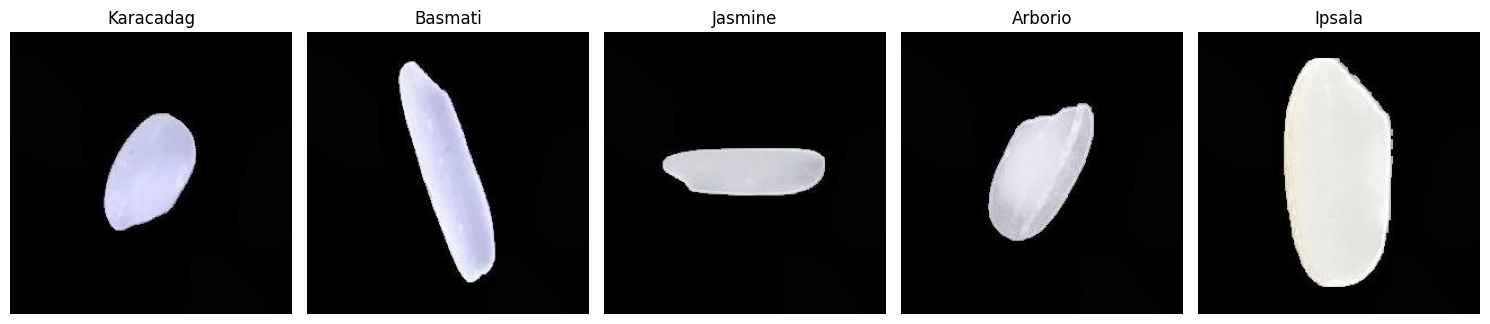

In [43]:
# Path ke folder dataset
base_path = path

# Ambil semua kategori
categories = [item for item in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, item))]
print("Kategori nasi:", categories)

# Menampilkan 5 gambar pertama dari seluruh folder
plt.figure(figsize=(15, 5))
count = 1

for category in categories:
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)

    if image_files:
        img_file_name = image_files[0]
        img_path = os.path.join(category_path, img_file_name)

        if os.path.isfile(img_path):
            try:
                img = mpimg.imread(img_path)
                plt.subplot(1, 5, count)
                plt.imshow(img)
                plt.title(category)
                plt.axis('off')
                count += 1
            except Exception as e:
                 print(f"Could not read image file {img_path}: {e}")

    if count > 5:
        break

plt.tight_layout()
plt.show()

Preprocessing

In [44]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (64, 64))

    # Gaussian filter
    gaussian = cv2.GaussianBlur(img_resized, (5, 5), 0)

    # Median filter
    median = cv2.medianBlur(gaussian, 5)

    # Histogram equalization dengan CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hist_eq = clahe.apply(median)

    # Contrast stretching
    p2, p98 = np.percentile(hist_eq, (2, 98))
    stretched = cv2.normalize(hist_eq, None, 0, 255, cv2.NORM_MINMAX)

    return img_resized, hist_eq, stretched

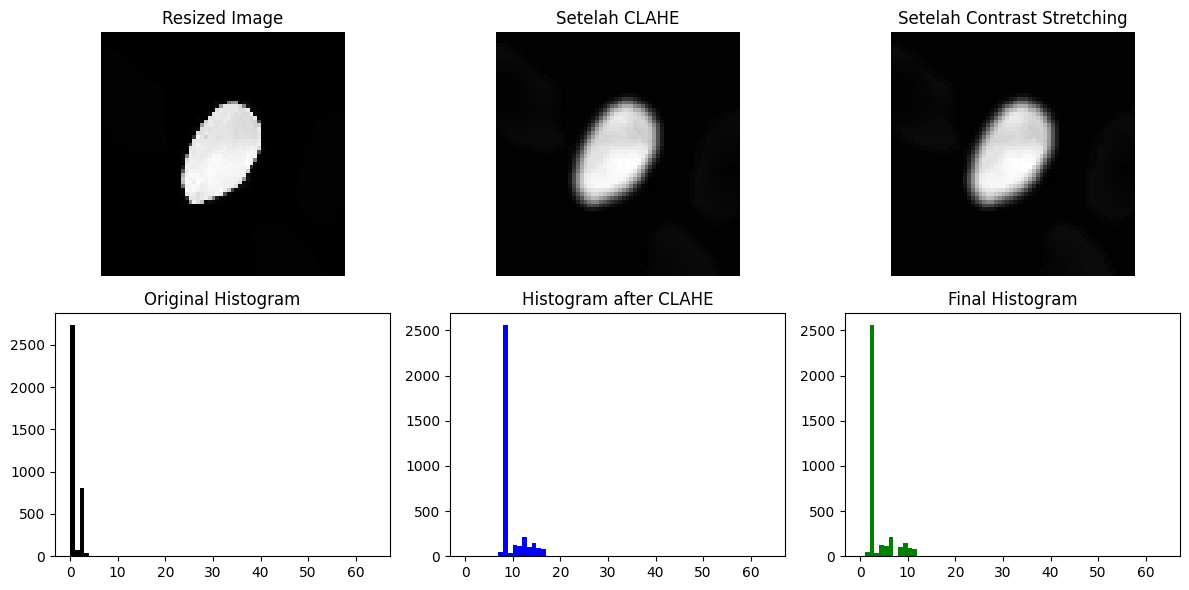

In [45]:
# Ambil 1 gambar dari kategori pertama
example_path = os.path.join(base_path, categories[0], os.listdir(os.path.join(base_path, categories[0]))[0])

# Preprocessing
original_resized, hist_eq_result, final_result = preprocess_image(example_path)

# Menampilkan gambar dan histogram
plt.figure(figsize=(12, 6))

# Gambar setelah resize
plt.subplot(2, 3, 1)
plt.imshow(original_resized, cmap='gray')
plt.title("Resized Image")
plt.axis('off')

# Histogram asli
plt.subplot(2, 3, 4)
plt.hist(original_resized.ravel(), bins=64, range=(0, 64), color='black')
plt.title("Original Histogram")

# Setelah CLAHE
plt.subplot(2, 3, 2)
plt.imshow(hist_eq_result, cmap='gray')
plt.title("Setelah CLAHE")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.hist(hist_eq_result.ravel(), bins=64, range=(0, 64), color='blue')
plt.title("Histogram after CLAHE")

# Setelah Contrast Stretching
plt.subplot(2, 3, 3)
plt.imshow(final_result, cmap='gray')
plt.title("Setelah Contrast Stretching")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.hist(final_result.ravel(), bins=64, range=(0, 64), color='green')
plt.title("Final Histogram")

plt.tight_layout()
plt.show()

Ekstraksi Fitur dengan GLCM dan Hu Moments

In [46]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image):
    # GLCM dari 4 arah (0, 45, 90, 135 derajat)
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten()
    }
    return features

def extract_hu_moments(image):
    # Ambil contour dari gambar biner
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(binary)
    huMoments = cv2.HuMoments(moments)
    # Log scale untuk stabilisasi nilai
    for i in range(0,7):
        huMoments[i] = -1 * np.sign(huMoments[i]) * np.log10(abs(huMoments[i])+1e-10)
    return huMoments.flatten()

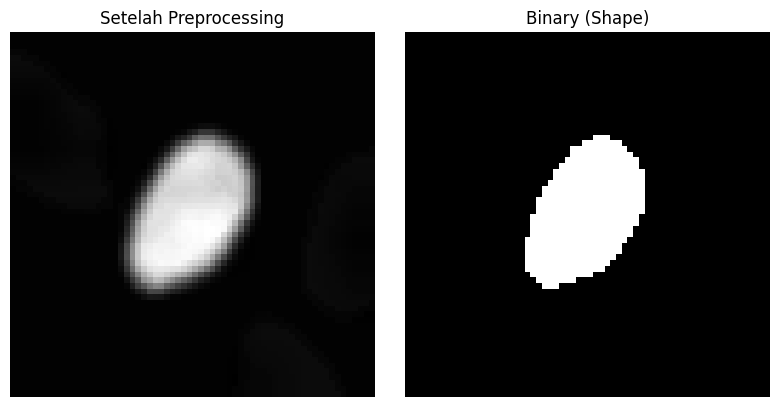

GLCM Features (truncated):
contrast: [123.73983135 277.42756362  87.890625   140.06601159]
correlation: [0.98393487 0.96447275 0.98858868 0.98206321]
energy: [0.60657323 0.59480857 0.60560769 0.59237338]
homogeneity: [0.78310577 0.74284022 0.77816635 0.72970743]

Hu Moments:
[  3.15045662   6.97449112   9.97322471   9.9984637   10.
   9.99999993 -10.        ]


In [47]:
# Memilih 1 gambar dari dataset
example_path = os.path.join(base_path, categories[0], os.listdir(os.path.join(base_path, categories[0]))[0])

# Preprocessing
original_resized, hist_eq_result, final_result = preprocess_image(example_path)
image_for_features = final_result

# Proses Ekstraksi Fitur
glcm_features = extract_glcm_features(image_for_features)
hu_features = extract_hu_moments(image_for_features)

# Threshold biner untuk visualisasi bentuk
_, binary = cv2.threshold(image_for_features, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Menampilkan gambar
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_for_features, cmap='gray')
plt.title("Setelah Preprocessing")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binary (Shape)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Menampilkan fitur
print("GLCM Features (truncated):")
for key, val in glcm_features.items():
    print(f"{key}: {val[:4]}")

print("\nHu Moments:")
print(hu_features)

Hyperparamter Tuning dan Klasifikasi

---- Memuat data dan mengekstraksi fitur ----
Data dan fitur berhasil dimuat.
Total sampel: 75000

---- Membagi data menjadi training, validation, dan testing ----
Jumlah data training: 60000
Jumlah data validation: 7500
Jumlah data testing: 7500

---- Melakukan tuning parameter n_neighbors untuk KNN ----
N = 1, Validation Accuracy = 0.9280
N = 2, Validation Accuracy = 0.9279
N = 3, Validation Accuracy = 0.9411
N = 4, Validation Accuracy = 0.9381
N = 5, Validation Accuracy = 0.9436
N = 6, Validation Accuracy = 0.9411
N = 7, Validation Accuracy = 0.9427
N = 8, Validation Accuracy = 0.9417
N = 9, Validation Accuracy = 0.9412
N = 10, Validation Accuracy = 0.9419

Nilai N terbaik pada data validation: 5


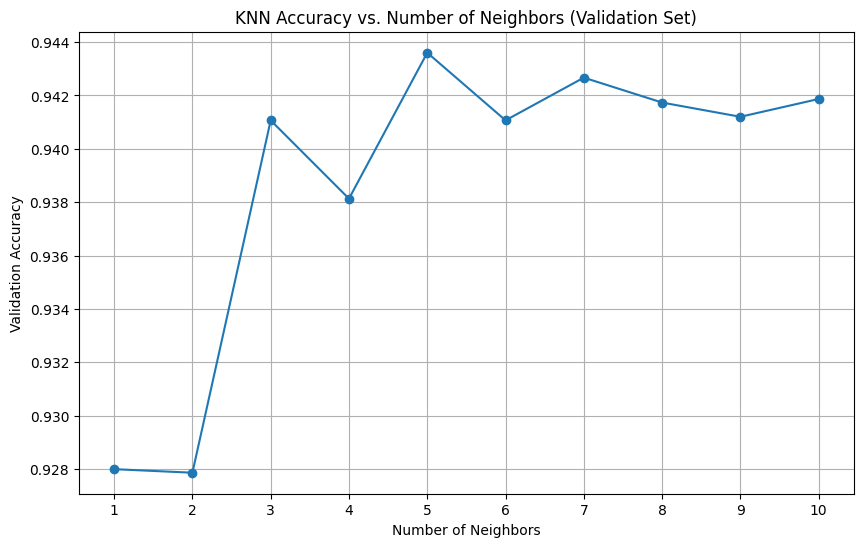

In [48]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load data dan ekstraksi fitur

data = []
labels = []

print("---- Memuat data dan mengekstraksi fitur ----")

for category_idx, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    if os.path.isdir(category_path):
        for img_file_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file_name)
            if os.path.isfile(img_path):
                try:
                    # Panggil fungsi preprocessing
                    _, _, processed_img_for_features = preprocess_image(img_path)
                    # Panggil fungsi ekstraksi fitur GLCM
                    glcm_features = extract_glcm_features(processed_img_for_features)
                    # Panggil fungsi ekstraksi fitur Hu Moments
                    hu_features = extract_hu_moments(processed_img_for_features)

                    # Gabungkan semua fitur jadi satu vektor NumPy
                    all_features = np.concatenate([
                        glcm_features['contrast'],
                        glcm_features['correlation'],
                        glcm_features['energy'],
                        glcm_features['homogeneity'],
                        hu_features
                    ])
                    data.append(all_features)
                    labels.append(category_idx)
                except Exception as e:
                    print(f"Melewatkan file {img_path} karena error: {e}")

X = np.array(data)
y = np.array(labels)

print("Data dan fitur berhasil dimuat.")
print(f"Total sampel: {len(X)}")

# Split: train (80%), val (10%), test (10%)
print("\n---- Membagi data menjadi training, validation, dan testing ----")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data validation: {len(X_val)}")
print(f"Jumlah data testing: {len(X_test)}")

# Tuning parameter n_neighbors
print("\n---- Melakukan tuning parameter n_neighbors untuk KNN ----")
neighbors_range = range(1, 11)
validation_accuracies = []

for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(acc)
    print(f"N = {n}, Validation Accuracy = {acc:.4f}")

# MEncari nilai N terbaik
best_n_neighbors = neighbors_range[np.argmax(validation_accuracies)]
print(f"\nNilai N terbaik pada data validation: {best_n_neighbors}")

# Visualisasi tuning
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, validation_accuracies, marker='o', linestyle='-')
plt.title('KNN Accuracy vs. Number of Neighbors (Validation Set)')
plt.xlabel('Number of Neighbors')
plt.ylabel('Validation Accuracy')
plt.xticks(neighbors_range)
plt.grid(True)
plt.show()


In [49]:
# Training ulang dengan N terbaik dan evaluasi di data testing
print(f"\n--- Pengujian Akhir dengan N = {best_n_neighbors} pada Data Testing ---")
knn_final = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_final.fit(X_train, y_train)
y_test_pred = knn_final.predict(X_test)


--- Pengujian Akhir dengan N = 5 pada Data Testing ---


Evaluasi

Confusion Matrix:
 [[1420    0    0   79    1]
 [   0 1447   53    0    0]
 [   0   87 1375   32    6]
 [ 134    0   10 1356    0]
 [   0    1   18    0 1481]]

Classification Report:
               precision    recall  f1-score   support

   Karacadag       0.91      0.95      0.93      1500
     Basmati       0.94      0.96      0.95      1500
     Jasmine       0.94      0.92      0.93      1500
     Arborio       0.92      0.90      0.91      1500
      Ipsala       1.00      0.99      0.99      1500

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500


Accuracy pada data testing dengan nilai N = 5: 0.9439


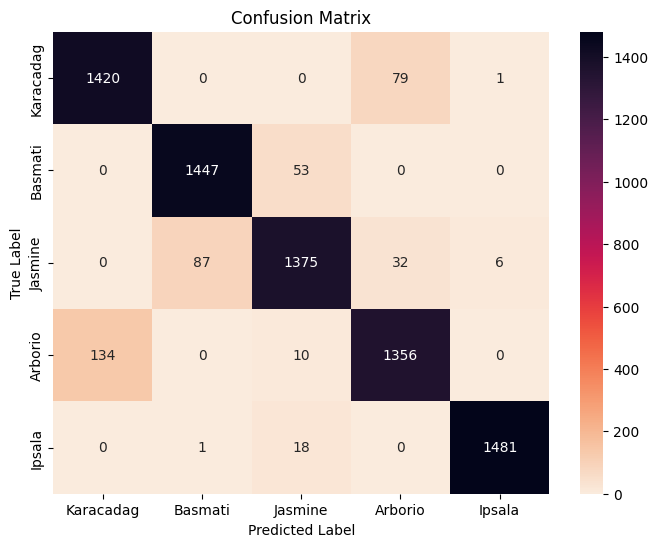

In [50]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=categories))
print(f"\nAccuracy pada data testing dengan nilai N = {best_n_neighbors}: {accuracy_score(y_test, y_test_pred):.4f}")

# Visualisasi Confusion Matrix dengan Heatmap
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()